# PixelCNN for FashionMNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb)

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision import transforms as Transforms

import torchinfo

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## 0. Train Parameters

In [2]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 8
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 64
EPOCHS = 100

## 1. Preparing FashionMNIST dataset

In [3]:
# Turn input image into (label-pixel representatin, pixel-wise labels)
def collate_fn(batch):
    batch = torch.stack([data[0] for data in batch])
    value_step = 1.0 / PIXEL_LEVELS
    labels = (batch / value_step).type(torch.long)
    imgs = labels.type(torch.float32) / PIXEL_LEVELS
    return imgs, labels

def get_dataloader(train=True):
    transform_fn = Transforms.Compose([
                        Transforms.ToTensor(),
                        Transforms.Resize(IMAGE_SIZE, antialias=True),                        
                    ])
    
    # Load FashionMNIST dataset
    fashion_ds = datasets.FashionMNIST('../../data', 
                                      train=train, 
                                      download=True,
                                      transform=transform_fn)

    # Get train dataloader
    dataloader = DataLoader(fashion_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=8, collate_fn=collate_fn)

    return dataloader

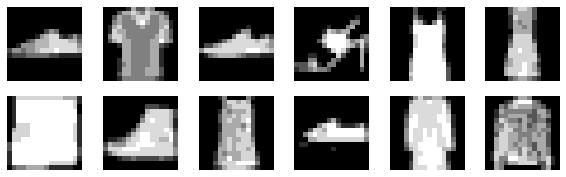

In [4]:
# Check dataset
def plot_imgs(batch, num_rows=2, num_cols=6):
    plt.figure(figsize=(10, 3))
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(batch[i], cmap='gray')
        ax.axis('off')
    plt.show()

test_loader = get_dataloader()
sample_data = next(iter(test_loader))

plot_imgs(sample_data[0].permute(0, 2, 3, 1))

## 2. Build the PixelCNN

This PyTorch implementation references pi-tau's GitHub repo: [Link](https://github.com/pi-tau/pixelcnn/blob/master/conv2d_mask.py)

In [5]:
# Building MaskedConv2D layer
class MaskedConv2D(nn.Conv2d):
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        kwargs['padding'] = 'same'
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)

        assert mask_type in ['A', 'B'], 'Mask type should be either A or B'
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        # Creating masks
        kh, kw = kernel_size
        mask = torch.ones_like(self.weight)
        mask[:, :, (kh // 2 + 1):, :] = 0
        mask[:, :, (kh // 2), (kw // 2 + 1):] = 0
        # If mask type is A, then masking the center pixel
        if mask_type == 'A':
            mask[:, :, (kh // 2), (kw // 2)] = 0

        # Making the mask the non-trainable parameter of the module
        self.register_buffer('mask', mask)

    def forward(self, x):
        return F.conv2d(x, self.weight * self.mask, 
                        stride=self.stride, padding=self.padding)

In [6]:
# Check the mask in the masked conv layer
print("Type \"A\" mask of the conv layer:")
print(MaskedConv2D('A', 1, 1, 5).mask.numpy())

print("\nType \"B\" mask of the conv layer:")
print(MaskedConv2D('B', 1, 1, 5).mask.numpy())

Type "A" mask of the conv layer:
[[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]]

Type "B" mask of the conv layer:
[[[[1. 1. 1. 1. 1.]
   [1. 1. 1. 1. 1.]
   [1. 1. 1. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]]


In [7]:
# Building the residual block
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # First regular 2D convolution
        self.conv_1 = nn.Sequential(
                        nn.Conv2d(in_channels=in_channels, 
                                  out_channels=out_channels // 2,
                                  kernel_size=1,
                                  stride=1),
                        nn.ReLU())

        # Type 'B' masked convolution
        self.pixel_conv = nn.Sequential(
                        MaskedConv2D(
                            mask_type='B',
                            in_channels=out_channels // 2,
                            out_channels=out_channels // 2,
                            kernel_size=3,
                            padding='same'),
                        nn.ReLU())

        # Second regular 2D convolution
        self.conv_2 = nn.Sequential(
                        nn.Conv2d(in_channels=out_channels // 2,
                                  out_channels=out_channels,
                                  kernel_size=1),
                        nn.ReLU())

    
    def forward(self, x):
        conv_x = self.conv_1(x)
        conv_x = self.pixel_conv(conv_x)
        conv_x = self.conv_2(conv_x)
        # Skip connection
        return conv_x + x        

In [8]:
class PixelCNN(nn.Module):

    def __init__(self, num_filters, num_res_blocks, ouput_size=PIXEL_LEVELS):
        super().__init__()
        self.masked_conv_1 = nn.Sequential( 
                                MaskedConv2D(
                                    mask_type='A',
                                    in_channels=1,
                                    out_channels=num_filters,
                                    kernel_size=7,
                                    stride=1,
                                    padding='same'),
                                nn.ReLU()
                             )

        self.res_convs = nn.Sequential(*[
                            ResidualBlock(
                                in_channels=num_filters,
                                out_channels=num_filters)
                            for _ in range(num_res_blocks)])

        self.masked_conv_2 = nn.Sequential(*[
                                nn.Sequential(
                                    MaskedConv2D(
                                        mask_type='B',
                                        in_channels=num_filters,
                                        out_channels=num_filters,
                                        kernel_size=1,
                                        padding='valid'),
                                    nn.ReLU())
                                for _ in range(2)],
                            )

        self.output_conv = nn.Conv2d(in_channels=num_filters,
                                     out_channels=ouput_size,
                                     kernel_size=1,
                                     stride=1,
                                     padding='valid')
        # We don't need a softmax layer when using CrossEntropy Loss in PyTorch

    def forward(self, x):
        x = self.masked_conv_1(x)
        x = self.res_convs(x)
        x = self.masked_conv_2(x)
        x = self.output_conv(x)
        # Manipulate the shape making predictions at the end of the output tensor
        x = x.reshape(x.shape[0], 1, PIXEL_LEVELS, IMAGE_SIZE, IMAGE_SIZE)
        x = x.permute(0, 1, 3, 4, 2) 
        return x

pixel_cnn = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS)
torchinfo.summary(model=pixel_cnn, input_size=(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
PixelCNN                                 [1, 1, 16, 16, 8]         --
├─Sequential: 1-1                        [1, 128, 16, 16]          --
│    └─MaskedConv2D: 2-1                 [1, 128, 16, 16]          6,400
│    └─ReLU: 2-2                         [1, 128, 16, 16]          --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─ResidualBlock: 2-3                [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 64, 16, 16]           8,256
│    │    └─Sequential: 3-2              [1, 64, 16, 16]           36,928
│    │    └─Sequential: 3-3              [1, 128, 16, 16]          8,320
│    └─ResidualBlock: 2-4                [1, 128, 16, 16]          --
│    │    └─Sequential: 3-4              [1, 64, 16, 16]           8,256
│    │    └─Sequential: 3-5              [1, 64, 16, 16]           36,928
│    │    └─Sequential: 3-6              [1, 128, 16, 16]        

## 3. Train step functions

In [9]:
class ImageGenerator:

    def __init__(self, num_imgs):
        self.num_imgs = num_imgs

    # Sample from the model's output distribution with temperature
    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / probs.sum()
        return np.random.choice(len(probs), p=probs)

    # Generate new image pixel-by-pixel
    def generate(self, model, temperature):
        model.eval()
        
        generated_imgs = np.zeros(shape=(self.num_imgs, 1, IMAGE_SIZE, IMAGE_SIZE))
        batch, channels, rows, cols = generated_imgs.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    with torch.no_grad():
                        probs = model(torch.tensor(generated_imgs, dtype=torch.float32).cuda())[:, :, row, col]
                    probs = nn.functional.softmax(probs, dim=-1).squeeze() # We don't have this layer in model
                    probs = probs.detach().cpu().numpy()
                    generated_imgs[:, channel, row, col] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_imgs[:, channel, row, col] /= PIXEL_LEVELS
        return generated_imgs

In [10]:
def trainer(model, dataloader, loss_fn, optim):
    model.train()
    train_loss = 0
    
    for imgs, targets in dataloader:
        imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
        optim.zero_grad()
        logits = model(imgs)
        
        loss = loss_fn(logits.reshape(-1, PIXEL_LEVELS), targets.reshape(-1))
        loss.backward()
        optim.step()
        train_loss += loss.item()

    return train_loss / len(dataloader)


def validation(model, dataloader, loss_fn):
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs, targets = imgs.to(DEVICE), targets.to(DEVICE)
            logits = model(imgs)   
            loss = loss_fn(logits.reshape(-1, PIXEL_LEVELS), targets.reshape(-1))
            valid_loss += loss.item()

    return valid_loss / len(dataloader)

## 4. Define the model, dataloader, objective, and optimizer

In [11]:
pixel_cnn = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS).to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(pixel_cnn.parameters(), lr=5e-4)

image_generator = ImageGenerator(12)

train_loader = get_dataloader(train=True)
valid_loader = get_dataloader(train=False)

Epoch   1	Time:0.09 min
	Train loss: 0.7049  Valid loss: 0.5868
Epoch   5	Time:0.09 min
	Train loss: 0.5333  Valid loss: 0.5289
Epoch  10	Time:0.09 min
	Train loss: 0.5085  Valid loss: 0.5113
Epoch  15	Time:0.09 min
	Train loss: 0.4952  Valid loss: 0.4950
Epoch  20	Time:0.09 min
	Train loss: 0.4847  Valid loss: 0.4866


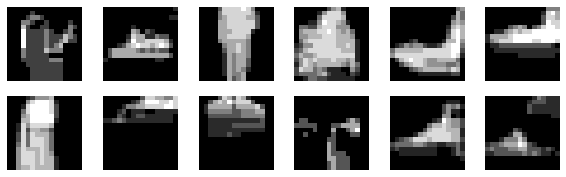

Epoch  25	Time:0.09 min
	Train loss: 0.4753  Valid loss: 0.4769
Epoch  30	Time:0.09 min
	Train loss: 0.4689  Valid loss: 0.4725
Epoch  35	Time:0.09 min
	Train loss: 0.4640  Valid loss: 0.4728
Epoch  40	Time:0.09 min
	Train loss: 0.4600  Valid loss: 0.4695


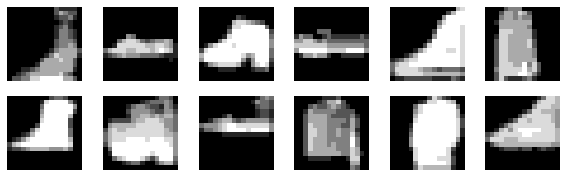

Epoch  45	Time:0.09 min
	Train loss: 0.4572  Valid loss: 0.4636
Epoch  50	Time:0.09 min
	Train loss: 0.4544  Valid loss: 0.4586
Epoch  55	Time:0.09 min
	Train loss: 0.4523  Valid loss: 0.4568
Epoch  60	Time:0.09 min
	Train loss: 0.4505  Valid loss: 0.4570


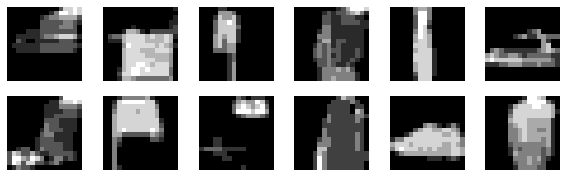

Epoch  65	Time:0.09 min
	Train loss: 0.4489  Valid loss: 0.4541
Epoch  70	Time:0.09 min
	Train loss: 0.4474  Valid loss: 0.4538
Epoch  75	Time:0.09 min
	Train loss: 0.4462  Valid loss: 0.4540
Epoch  80	Time:0.09 min
	Train loss: 0.4451  Valid loss: 0.4551


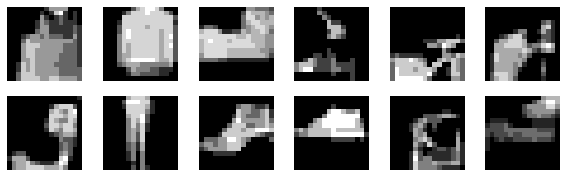

Epoch  85	Time:0.09 min
	Train loss: 0.4440  Valid loss: 0.4517
Epoch  90	Time:0.09 min
	Train loss: 0.4433  Valid loss: 0.4532
Epoch  95	Time:0.09 min
	Train loss: 0.4425  Valid loss: 0.4526
Epoch 100	Time:0.09 min
	Train loss: 0.4417  Valid loss: 0.4506


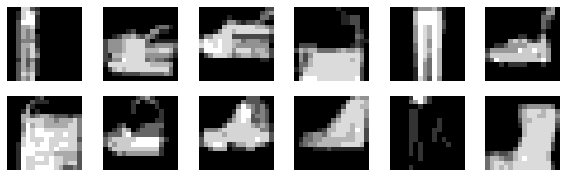

In [12]:
for i in range(EPOCHS):
    prev_time = time.time()
    
    train_loss = trainer(pixel_cnn, train_loader, loss_fn, optim)
    valid_loss = validation(pixel_cnn, valid_loader, loss_fn)
    
    curr_time = time.time()

    if i == 0 or (i + 1) % 5 == 0:
        print(f'Epoch {i+1:3d}\tTime:{(curr_time - prev_time) / 60:.2f} min')
        print(f'\tTrain loss: {train_loss:.4f}  Valid loss: {valid_loss:.4f}')
    
    if (i + 1) % 20 == 0:
        generated_imgs = image_generator.generate(pixel_cnn, 1.0)
        generated_imgs = np.transpose(generated_imgs, (0, 2, 3, 1))
        plot_imgs(generated_imgs)

## 5. Generate Images

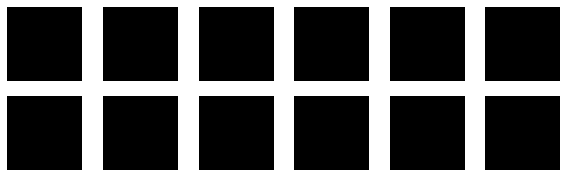

In [13]:
# With temperature = 0.1
generated_imgs = image_generator.generate(pixel_cnn, 0.1)
generated_imgs = np.transpose(generated_imgs, (0, 2, 3, 1))
plot_imgs(generated_imgs)

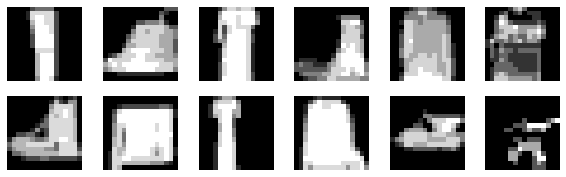

In [14]:
# With temperature = 1.0
generated_imgs = image_generator.generate(pixel_cnn, 1.0)
generated_imgs = np.transpose(generated_imgs, (0, 2, 3, 1))
plot_imgs(generated_imgs)